In [1]:
import torch
import os
import random
import pickle
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data.dataset import Dataset
import torchsummary
from matplotlib import pyplot as plt
from skimage.io import imread, imshow
from tqdm import tqdm

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)
torch.cuda.manual_seed(123)
torch.backends.cudnn.deterministic = True

In [4]:
from torch.utils.data.dataset import Dataset
from PIL import Image

In [5]:
def image_loader(path):
    """Image Loader helper function."""
    return Image.open(path.rstrip("\n")).convert('RGB')


class TripletDataset(Dataset):
   
    def __init__(self, triplet_path, transform=None, train=True, loader=image_loader):
        """
        Image Loader Builder.
        Args:
            base_path: path to triplets.txt
            filenames_filename: text file with each line containing the path to an image e.g., `images/class1/sample.JPEG`
            triplets_filename: A text file with each line containing three images
            transform: torchvision.transforms
            loader: loader for each image
        """
#         self.base_path = base_path
        self.transform = transform
        self.loader = loader

        self.train_flag = train
        
        # load training data
        if self.train_flag:
            with open(triplet_path, 'rb') as f:
                triplets = pickle.load(f)
            self.triplets = triplets
        else:
            with open(triplet_path, 'rb') as f:
                val_triplets = pickle.load(f)
            self.triplets = val_triplets
            

    def __getitem__(self, index):
        """Get triplets in dataset."""
        # get trainig triplets
        
        path1, path2, path3 = self.triplets[index]
        q = self.loader(path1)
        p = self.loader(path2)
        n = self.loader(path3)
        if self.transform is not None:
            q = self.transform(q)
            p = self.transform(p)
            n = self.transform(n)
        return q, p, n

        # get test image
#         else:
#             img = self.singletons[index]
#             if self.transform is not None:
#                 img = self.transform(img)
#             return img

    def __len__(self):
        """Get the length of dataset."""
        return len(self.triplets)
#         else:
#             return len(self.singletons)

In [6]:
# Normalize training set together with augmentation
one_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.0069], [0.0033])
])


# Loading Tiny ImageNet dataset
trplt_path = '../data/pickles/triplets_big.p'
val_trplt_path = '../data/pickles/val_triplets.p'
batch_szie = 128
trainset = TripletDataset(triplet_path=trplt_path, transform=one_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_szie, num_workers=8, shuffle=True, drop_last=True)

valset = TripletDataset(train=False, triplet_path=val_trplt_path, transform=one_transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_szie, num_workers=8)

# testset = TripletImageLoader(
#     base_path=root, triplets_filename="", transform=transform_test, train=False)
# testloader = torch.utils.data.DataLoader(
#     testset, batch_size=batch_size_test, num_workers=32)

In [7]:
len(trainset), len(trainloader)

(20000, 156)

In [8]:
len(valset), len(valloader)

(2000, 16)

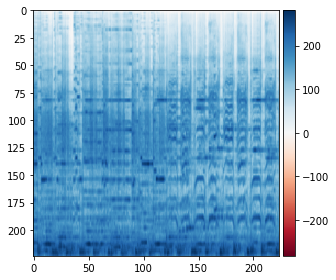

In [9]:
imshow(valset[1][0].numpy().transpose(1,2,0))

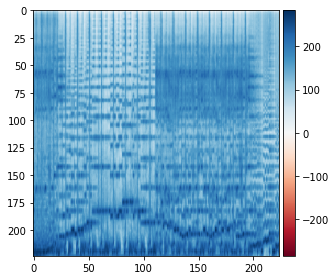

In [10]:
imshow(valset[1][1].numpy().transpose(1,2,0))

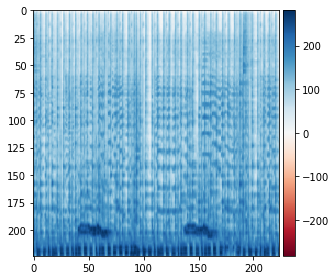

In [11]:
imshow(valset[1][2].numpy().transpose(1,2,0))

In [12]:
def fit_epoch(net, criterion, optimizer, loader, epoch):
    """
    Training process.
    Args:
        net: Triplet Net
        criterion: TripletMarginLoss
        optimizer: SGD with momentum optimizer
        scheduler: scheduler
        trainloader: training set loader
        testloader: test set loader
        start_epoch: checkpoint saved epoch
        epochs: training epochs
        is_gpu: whether use GPU
    """
    running_loss = 0.0
    for batch_idx, (data1, data2, data3) in enumerate(loader):

        data1, data2, data3 = data1.cuda(), data2.cuda(), data3.cuda()

        # wrap in torch.autograd.Variable
#             data1, data2, data3 = Variable(
#                 data1), Variable(data2), Variable(data3)

        # compute output and loss
        embedded_a, embedded_p, embedded_n = net(data1, data2, data3)
        loss = criterion(embedded_a, embedded_p, embedded_n)

        # compute gradient and do optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

#             if batch_idx % 30 == 0:
#                 print("mini Batch Loss: {}".format(loss.data[0]))

    # Normalizing the loss by the total number of train batches
    running_loss /= len(loader)
    print("Training Epoch: {0} | Train Loss: {1}".format(epoch+1, running_loss))
    return running_loss

In [13]:
def eval_epoch(net, criterion, loader, epoch):
    net.eval()
    running_loss = 0.0
    for batch_idx, (data1, data2, data3) in enumerate(loader):
        data1, data2, data3 = data1.cuda(), data2.cuda(), data3.cuda()
        
        with torch.set_grad_enabled(False):
            embedded_a, embedded_p, embedded_n = net(data1, data2, data3)
            loss = criterion(embedded_a, embedded_p, embedded_n)
        running_loss += loss.item()
    running_loss /= len(loader)
    print("Training Epoch: {0} | Val Loss: {1}".format(epoch+1, running_loss))
    return running_loss

In [14]:
def train(net, criterion, optimizer, scheduler, trainloader, valloader, epochs):
    for epoch in range(epochs):
        net.train()
        train_loss = fit_epoch(net, criterion, optimizer, trainloader, epoch)
        val_loss = eval_epoch(net, criterion, valloader, epoch)
        history.append((train_loss, val_loss))
        scheduler.step()
        

In [32]:
class EmbeddingNet(nn.Module):
    """EmbeddingNet using ResNet-101."""

    def __init__(self, resnet):
        """Initialize EmbeddingNet model."""
        super(EmbeddingNet, self).__init__()

        # Everything except the last linear layer
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        num_ftrs = resnet.fc.in_features
        self.fc1 = nn.Sequential(
            nn.Linear(num_ftrs, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(2048, 1024)
        )

    def forward(self, x):
        """Forward pass of EmbeddingNet."""
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)

        return out


class TripletNet(torch.nn.Module):
    """Triplet Network."""

    def __init__(self, embeddingnet):
        """Triplet Network Builder."""
        super(TripletNet, self).__init__()
        self.embeddingnet = embeddingnet

    def forward(self, a, p, n):
        """Forward pass."""
        # anchor
        embedded_a = self.embeddingnet(a)

        # positive examples
        embedded_p = self.embeddingnet(p)

        # negative examples
        embedded_n = self.embeddingnet(n)

        return embedded_a, embedded_p, embedded_n

In [38]:
resnet = torchvision.models.resnet18(pretrained=True)
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
for param in resnet.parameters():
    param.requires_grad = False
for param in resnet.layer4[1:3].parameters():
    param.requires_grad = True
    
model = TripletNet(EmbeddingNet(resnet))

In [39]:
# torchsummary.summary(resnet.cuda(), (1, 128, 1248))

In [40]:
history = list()
criterion = nn.TripletMarginLoss(margin=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-4, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.5)

In [41]:
model = model.to(device)

In [42]:
train(model, criterion, optimizer, scheduler, trainloader, valloader, 10)

Training Epoch: 1 | Train Loss: 0.7929112108854147
Training Epoch: 1 | Val Loss: 0.636095879599452
Training Epoch: 2 | Train Loss: 0.5015374741111046
Training Epoch: 2 | Val Loss: 0.4735194519162178
Training Epoch: 3 | Train Loss: 0.335005270364957
Training Epoch: 3 | Val Loss: 0.3816964980214834
Training Epoch: 4 | Train Loss: 0.23158888757610932
Training Epoch: 4 | Val Loss: 0.34373232163488865
Training Epoch: 5 | Train Loss: 0.1715812935756567
Training Epoch: 5 | Val Loss: 0.2669082395732403
Training Epoch: 6 | Train Loss: 0.09623172786086798
Training Epoch: 6 | Val Loss: 0.22023864090442657
Training Epoch: 7 | Train Loss: 0.06170150094355146
Training Epoch: 7 | Val Loss: 0.24832417909055948
Training Epoch: 8 | Train Loss: 0.05528633600960557
Training Epoch: 8 | Val Loss: 0.21439962182193995
Training Epoch: 9 | Train Loss: 0.04564311446096653
Training Epoch: 9 | Val Loss: 0.22208923660218716
Training Epoch: 10 | Train Loss: 0.04902306374592277
Training Epoch: 10 | Val Loss: 0.216470

In [45]:
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-5, weight_decay=0.01)
train(model, criterion, optimizer, scheduler, trainloader, valloader, 3)

Training Epoch: 1 | Train Loss: 0.025795500522527177
Training Epoch: 1 | Val Loss: 0.182492651976645
Training Epoch: 2 | Train Loss: 0.015138248483148905
Training Epoch: 2 | Val Loss: 0.17240494629368186
Training Epoch: 3 | Train Loss: 0.012438319372729613
Training Epoch: 3 | Val Loss: 0.1730890111066401


In [57]:
for param in model.embeddingnet.features[7].parameters():
    param.requires_grad = True

In [58]:
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-6, weight_decay=0.01)
train(model, criterion, optimizer, scheduler, trainloader, valloader, 3)

Training Epoch: 1 | Train Loss: 0.010243400316446638
Training Epoch: 1 | Val Loss: 0.16629404248669744
Training Epoch: 2 | Train Loss: 0.00824031395574984
Training Epoch: 2 | Val Loss: 0.1648379764519632
Training Epoch: 3 | Train Loss: 0.0074626328722120095
Training Epoch: 3 | Val Loss: 0.16236239485442638


In [60]:
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-6, weight_decay=0.01)
train(model, criterion, optimizer, scheduler, trainloader, valloader, 3)

Training Epoch: 1 | Train Loss: 0.007614271351112387
Training Epoch: 1 | Val Loss: 0.1626840215176344
Training Epoch: 2 | Train Loss: 0.00714663066304265
Training Epoch: 2 | Val Loss: 0.16292840195819736
Training Epoch: 3 | Train Loss: 0.00624985336803664
Training Epoch: 3 | Val Loss: 0.16265786672011018


In [59]:
torch.save(model, '../data/pickles/model_triplet.pth')

In [61]:
loss, val_loss = zip(*history)

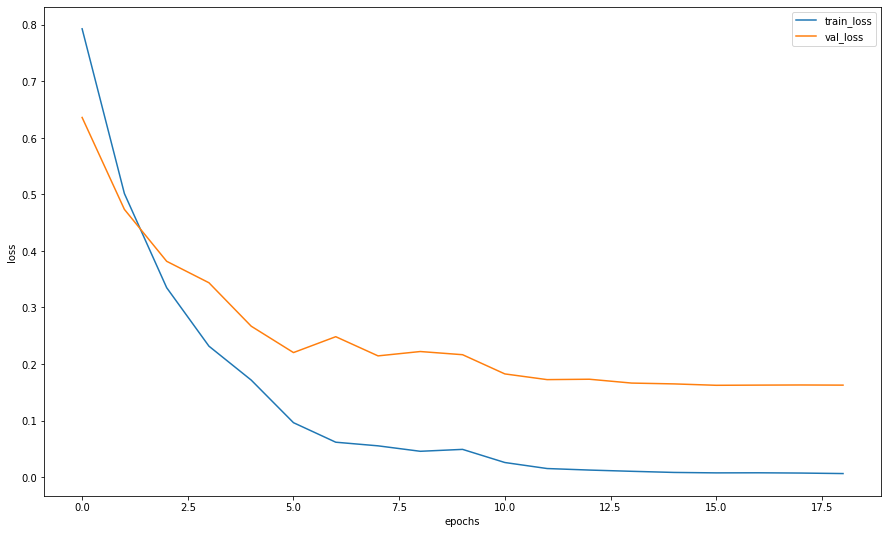

In [62]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()